# Librerias

In [23]:
pip install tensorflow

In [24]:
import numpy as np
import matplotlib as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import warnings
import re
warnings.filterwarnings("ignore")


# Preprocesamiento

In [25]:
def clean_text(text, keep_emojis=False, fix_contractions=False):
    text = re.sub(r"\.{2,}", "...", text)  # Ellipses
    text = re.sub(r"!{2,}", "!", text)     # !
    text = re.sub(r"\?{2,}", "?", text)    # ?
    text = re.sub(r"[^a-zA-Z0-9\s!?.]", "", text.lower())

    return text


In [26]:
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [36]:
df=pd.read_csv('tweet_emotions.csv')
#remove sentiment=empty
df.drop(df[df['sentiment']=='empty'].index, inplace=True)
df.loc[df['sentiment'] == 'hate', 'sentiment'] = 'anger'
df.loc[df['sentiment'] == 'boredom', 'sentiment'] = 'neutral'
df.loc[df['sentiment'] == 'enthusiasm', 'sentiment'] = 'fun'
sentimentlabels=df.sentiment.unique()

In [28]:
text=df['content']
sentiment=df['sentiment']
print(sentiment.unique())
sentiment.replace(sentiment.unique(),range(9),inplace=True)
print(sentiment.shape,text.shape)

['sadness' 'fun' 'neutral' 'worry' 'surprise' 'love' 'anger' 'happiness'
 'relief']
(39173,) (39173,)


In [29]:
cleaned_text = text.apply(clean_text)
tokenized=cleaned_text.apply(word_tokenize)
tokenized=tokenized.apply(lambda x: [word for word in x if word not in stopwords.words('english')])

In [30]:
#padding
MAX_LEN=12
tokenizer = Tokenizer(num_words=3000, oov_token="<OOV>")
tokenizer.fit_on_texts(tokenized)
sequences = tokenizer.texts_to_sequences(tokenized)
X = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")
y=np.array(sentiment)
# One-hot encoding
y_onehot = to_categorical(y,num_classes=9)

# Modelo

In [31]:
num_classes = 9

model = Sequential([
    Embedding(input_dim=3000, output_dim=128, input_length=MAX_LEN),
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y) #para balancear el peso entre clases
class_weights = dict(enumerate(class_weights))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=1341,shuffle=True)
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=early_stopping,
                    class_weight=class_weights,
                    batch_size=64)

Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step - accuracy: 0.1647 - loss: 2.1528 - val_accuracy: 0.1948 - val_loss: 2.0640
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 68s 79ms/step - accuracy: 0.2696 - loss: 1.9378 - val_accuracy: 0.2839 - val_loss: 1.9530
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.3018 - loss: 1.8482 - val_accuracy: 0.2729 - val_loss: 1.9454
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.3221 - loss: 1.7564 - val_accuracy: 0.2859 - val_loss: 1.9273
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.3353 - loss: 1.7126 - val_accuracy: 0.2841 - val_loss: 1.9341
Epoch 6/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.3481 - loss: 1.6643 - val_accuracy: 0.2680 - val_loss: 2.0046
Epoch 7/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.3622 - loss: 1.6260 - val_accuracy: 0.2720 - val_loss: 1.9747
Epoch 8/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.3677 - loss: 1.5737 -

245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


<Axes: >

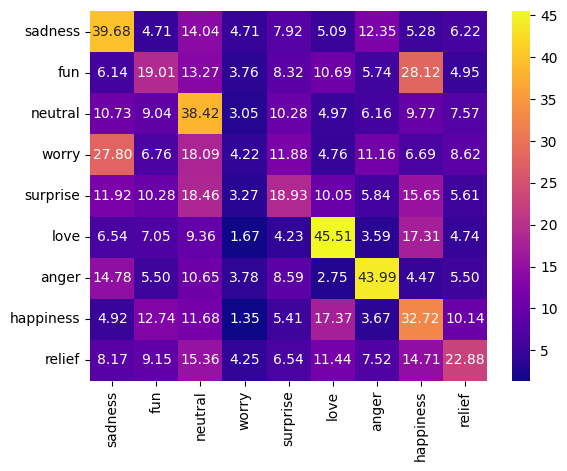

In [37]:
#confusion matrix por porcentaje para interpretar mejor con clases desbalanceadas
cm=confusion_matrix(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))
cm=cm/cm.sum(axis=1,keepdims=True)*100
sns.heatmap(cm,annot=True,fmt='.2f',xticklabels=df.sentiment.unique(),yticklabels=df.sentiment.unique(),cmap='plasma')

In [34]:
def emociones(text):
  cleaned_text=clean_text(text)
  tokenized=word_tokenize(cleaned_text)
  tokenized=[word for word in tokenized if word not in stopwords.words('english')]
  tokenized=tokenizer.texts_to_sequences([tokenized])
  tokenized=pad_sequences(tokenized, maxlen=MAX_LEN, padding="post", truncating="post")
  results=np.round(np.array(model.predict(tokenized))[0],4)
  tabla=np.array(list(zip(df.sentiment.unique(), results)))
  tabla=tabla[tabla[:,1].argsort()[::-1]]
  return tabla[:2,0] #Regresa las 2 emociones mas probables segun el modelo

In [38]:
emociones("Thank you")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


array(['relief', 'neutral'], dtype='<U32')